## Task : Implementing the triplet loss function and using the facenet modell to map the images to 128 dimensional encodings and using these encodings perform face recognition

### Note -- All images and utils are of deeplearning.ai specialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation,Input,concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from fr_utils import *
from inception_blocks_v2 import *


Instructions for updating:
non-resource variables are not supported in the long term


The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning, let's load weights that someone else has already trained. The network architecture follows the Inception model from their research paper

In [30]:
FRmodel = faceRecoModel(input_shape=(3,96,96))

In [31]:
print('total params : ', FRmodel.count_params())

total params :  3743280




By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

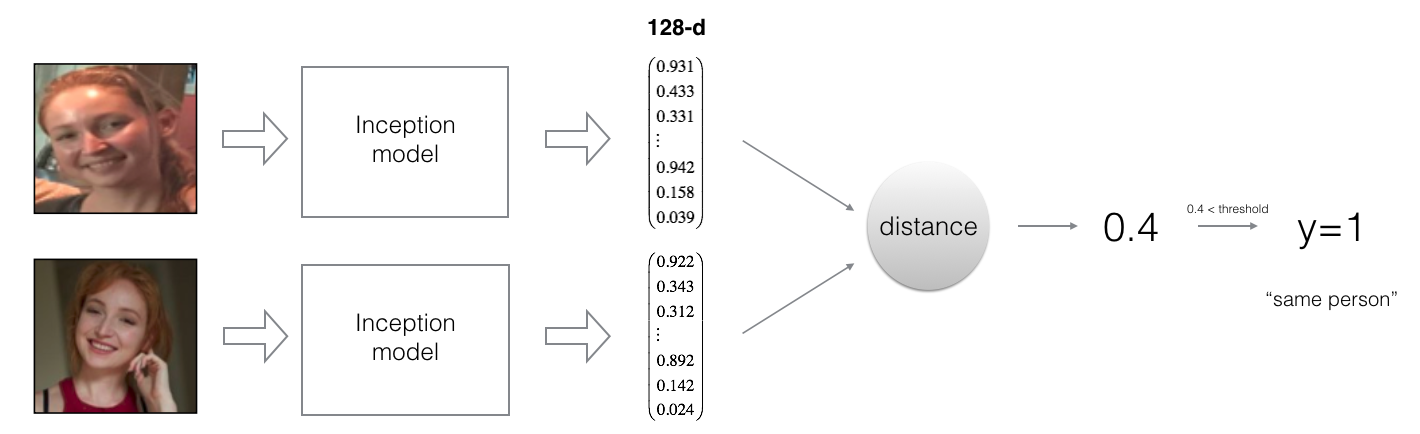

So, an encoding is a good one if:

   - The encodings of two images of the same person are quite similar to each other.
   - The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

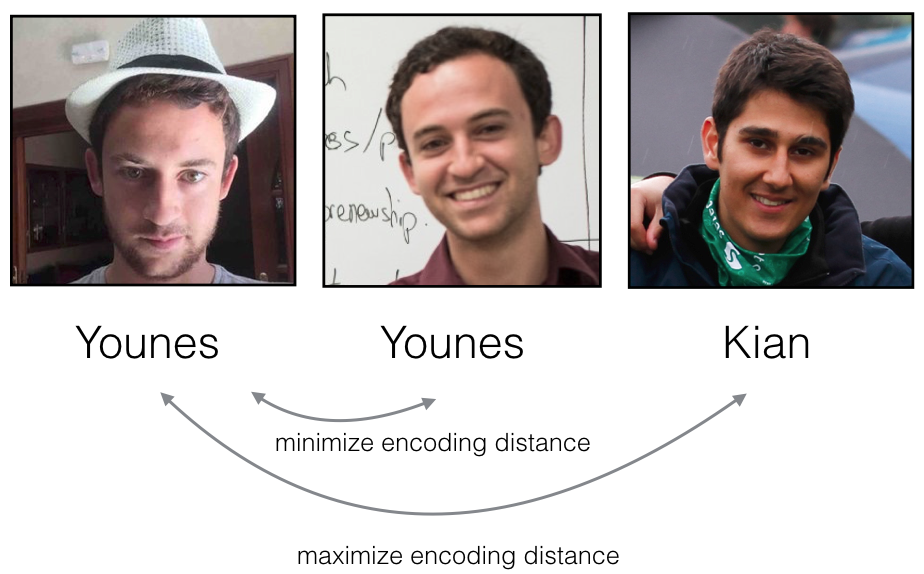

# The triplet loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

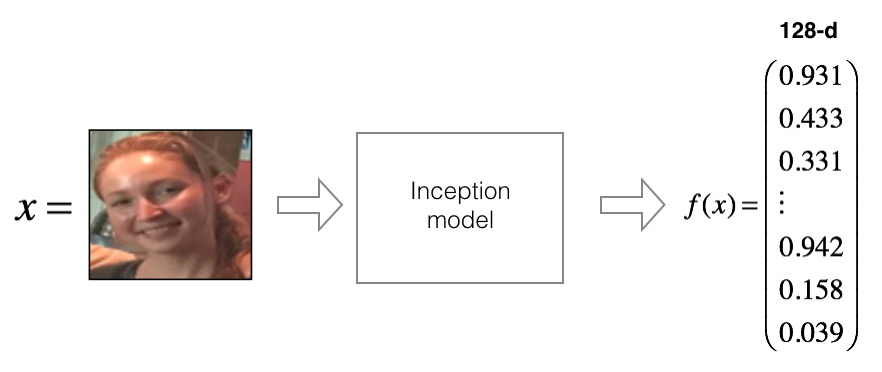


Training will use triplets of images $(A, P, N)$:

 -   A is an "Anchor" image--a picture of a person.
 -   P is a "Positive" image--a picture of the same person as the Anchor image.
 -   N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example.

1. You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin alpha :



2. You would thus like to minimize the following "triplet cost": 
$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.

Notes:

   - The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
   
   - The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
   
   - $\alpha$ is called the margin. It is a hyperparameter that you pick manually. We will use $\alpha = 0.2$.


In [32]:
def triplet_loss(y_true,y_pred,alpha = 0.2) : 
    
    anchor,positive,negative = y_pred[0],y_pred[1],y_pred[2]
    
    # Calculating the (encoding) distance between anchor and the positive,summing over axis = -1
    pos_dist = tf.reduce_sum(tf.square(anchor - positive),axis = -1)
    
    # Calculating the (encoding) distance between anchor and the negative,summing over axis = -1
    neg_dist = tf.reduce_sum(tf.square(anchor - negative),axis = -1)
    
    # Subtracting the two_previous distances and adding alpha
    basic_loss = pos_dist - neg_dist + alpha
    
    # Takign max of basic_loss and 0 
    # summing over all training examples
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))

    return loss

In [33]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [34]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))


loss = 528.1426


## Loading the pre-trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. 

In [ ]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## Applying the model 

Let's build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding we use img_to_encoding(image_path, model), which runs the forward propagation of the model on the specified image.

In [ ]:
database = {}
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [36]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    #  Compute the encoding for the image. Use img_to_encoding() see example above.
    encoding = img_to_encoding(image_path, model)
    
    #  Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    #  Open the door if dist < 0.7, else don't open 
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
  
        
    return dist, door_open

In [ ]:
verify("images/camera_0.jpg", "younes", database, FRmodel)


### Works with gpu, on cpu need to change the input shape of model from (3,96,96) to (96,96,3)